In [1]:
from qiskit import transpile, schedule, assemble
import pickle
from qiskit import pulse, execute, QuantumCircuit
from qiskit.pulse.library import GaussianSquare
from qiskit.pulse import Schedule, Play, Acquire
import numpy as np
import typing
import matplotlib.pyplot as plt
from qiskit.pulse.channels import DriveChannel, ControlChannel, AcquireChannel, MeasureChannel, MemorySlot
from qiskit import IBMQ
from qiskit.pulse.instructions.play import Play
from qiskit.transpiler.passes.scheduling.calibration_creators import RZXCalibrationBuilder
from qiskit.circuit import Gate, Instruction
from qiskit.circuit import Parameter
from qiskit.scheduler.schedule_circuit import schedule_circuit


In [2]:
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter, TomographyFitter
from qiskit.ignis.verification import marginal_counts
from qiskit.quantum_info.operators.channel import Choi, Kraus, PTM
from qiskit.circuit import QuantumCircuit, QuantumRegister, Gate
from qiskit import transpile, schedule, assemble


In [3]:
from qiskit.providers.aer.noise.errors.errorutils import standard_gate_unitary
from qiskit.quantum_info.operators.measures import process_fidelity
from qiskit.quantum_info import Choi, Kraus, Operator
import qiskit.quantum_info as qi

In [4]:
provider = IBMQ.load_account()

In [5]:
provider_pulse = IBMQ.get_provider(hub='ibm-q-startup', group='phasecraft-ltd', project='pulse-level-cont')

In [6]:
#provider_pulse = IBMQ.get_provider(hub='ibm-q-startup', group='phasecraft-ltd', project='reservations')


In [7]:
device_name = "ibmq_casablanca"
backend = provider_pulse.get_backend(device_name)

config = backend.configuration()
props = backend.properties()
defaults = backend.defaults()

calibrations = defaults.instruction_schedule_map
basis_gates = config.basis_gates
inst_map = defaults.instruction_schedule_map

RZX_cals = RZXCalibrationBuilder(backend)

# Adding Scaled gates to instruction map

In [8]:
def t1(angle,*, z=0):
    
    

    if (0 <= angle < np.pi / 2) or (np.pi <= angle < 3 * np.pi / 2):
        return (1 / 2) * np.arctan2(
            ((-1)**z)*np.sqrt(np.sin(2 * angle)) / (np.cos(angle) + np.sin(angle)),
            1 / (np.cos(angle) + np.sin(angle)),
        )
    
    if (np.pi / 2 <= angle < np.pi) or (3 * np.pi / 2 <= angle < 2 * np.pi):
        return (1 / 2) * np.arctan2(
            - ((-1)**z)*(np.sqrt(-np.sin(2 * angle)) / (np.cos(angle) - np.sin(angle))),
            1 / (np.cos(angle) - np.sin(angle)),
        )
      
        
def t2(angle,*, z=0):
    
    if (0 <= angle < np.pi / 2) or (np.pi <= angle < 3 * np.pi / 2):
        
        return (1 / 2) * np.arctan2(
                            - ((-1)**z)*np.sqrt(np.sin(2 * angle)),
                                np.cos(angle) - np.sin(angle)
                                    )
    
    if (np.pi / 2 <= angle < np.pi) or (3 * np.pi / 2 <= angle < 2 * np.pi):
       
        return (1 / 2) * np.arctan2(
            - ((-1)**z)*np.sqrt(-np.sin(2 * angle)),
            np.cos(angle) + np.sin(angle)
        )

In [10]:
gate_name = 'scaled_rzx'
qubits = [4, 5, 6] #pick experiment qubits now!

def get_sched_q0q1(theta):
    qs = [qubits[0], qubits[1]]
    return RZX_cals.get_calibration([theta], qs)

def get_sched_q1q2(theta):
    qs = [qubits[1], qubits[2]]
    return RZX_cals.get_calibration([theta], qs)


basis_gates += [gate_name]
inst_map.add(gate_name, 
             [qubits[0], qubits[1]],
             get_sched_q0q1, 
             arguments=['theta'])

inst_map.add(gate_name, 
             [qubits[1], qubits[2]],
             get_sched_q1q2, 
             arguments=['theta'])

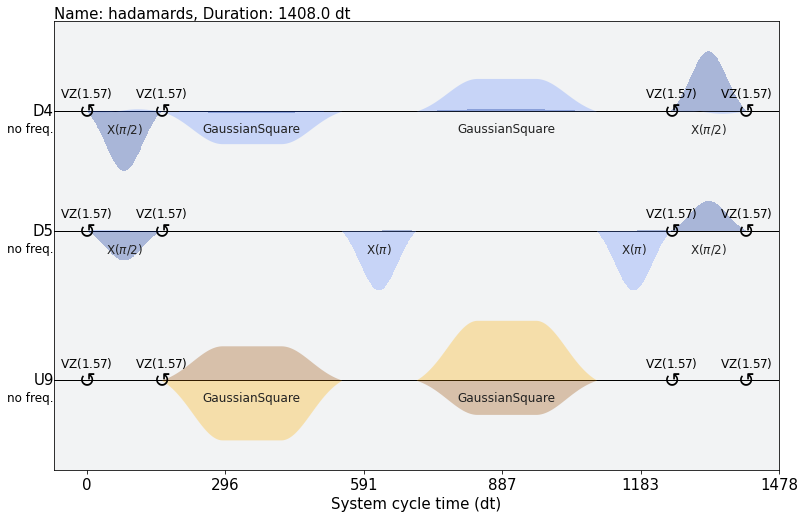

In [11]:
inst_map.get('scaled_rzx', (qubits[0], qubits[1]), theta= 0.8).draw()

# Depth 4

In [12]:
def get_depth4(t):
    
    g1 = Gate('scaled_rzx', 2, params = [2*t1(t)] )
    g2 = Gate('scaled_rzx', 2, params = [2*t2(t)] )


    qregs = QuantumRegister(config.n_qubits)
    qc = QuantumCircuit(qregs)

    qc.append(g1, (qregs[qubits[0]], qregs[qubits[1]]))
    qc.append(g2, (qregs[qubits[1]], qregs[qubits[2]]))
    qc.append(g2, (qregs[qubits[0]], qregs[qubits[1]]))
    qc.append(g1, (qregs[qubits[1]], qregs[qubits[2]]))
    
    return qc

In [13]:
get_depth4(1.0).draw()

»
q0_0: ────────────────────────────────────────────────────────────────────────»
                                                                              »
q0_1: ────────────────────────────────────────────────────────────────────────»
                                                                              »
q0_2: ────────────────────────────────────────────────────────────────────────»
                                                                              »
q0_3: ────────────────────────────────────────────────────────────────────────»
      ┌──────────────────────┐                        ┌──────────────────────┐»
q0_4: ┤0                     ├────────────────────────┤0                     ├»
      │  scaled_rzx(0.76164) │┌──────────────────────┐│  scaled_rzx(-1.8767) │»
q0_5: ┤1                     ├┤0                     ├┤1                     ├»
      └──────────────────────┘│  scaled_rzx(-1.8767) │└──────────────────────┘»
q0_6: ────────────────────────┤1                     ├────────────────────────»
                              └──────────────────────┘                        »
«                              
«q0_0: ────────────────────────
«                              
«q0_1: ────────────────────────
«                              
«q0_2: ────────────────────────
«                              
«q0_3: ────────────────────────
«                              
«q0_4: ────────────────────────
«      ┌──────────────────────┐
«q0_5: ┤0                     ├
«      │  scaled_rzx(0.76164) │
«q0_6: ┤1                     ├
«      └──────────────────────┘

In [ ]:
#angles15 =  [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
#angles14 =  [0.1, 0.2,0.3, 0.4, 0.6, 0.8, 1.0]

In [118]:
label = "16.June"

qpt_experiments = {}

angles =[0.025, 0.05 ,0.075]  #[0.125, 0.175, 0.225]#, 0.8] #[0.1, 0.15, 0.2, 0.25, 0.3, 0.35]# [0.4, 0.45, 0.5, 0.55, 0.6]

for angle in angles:
    
    qc = get_depth4(angle)
    
    qpt_circuits = process_tomography_circuits(qc, [qubits[0], qubits[1], qubits[2]])
                                            
    
    qpt_circuits_transpiled = transpile(qpt_circuits, backend, basis_gates) # withou
    qpt_schedules = schedule(qpt_circuits_transpiled, backend, inst_map)
    
    qpt_experiments[str(angle)] = {'pre_transpiled_circuits': qpt_circuits,
                                   'transpiled_circuits': qpt_circuits_transpiled,
                                   'qpt_schedules': qpt_schedules}
    
with open(f'results/{device_name}/{label}/depth4/qpt_exps.q4q5q6.pickle', 'wb') as handle:
        pickle.dump(qpt_experiments, handle, protocol=pickle.HIGHEST_PROTOCOL)

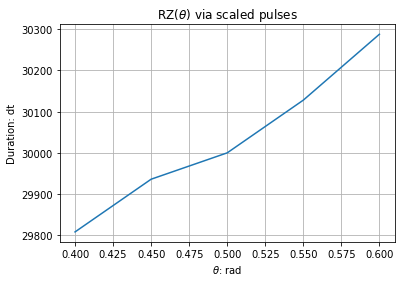

In [48]:
#measurement pulse really dominates!!!! 

qpt_schedule_durations = [qpt_experiments[f'{angle}']['qpt_schedules'][0].duration for angle in angles]

plt.plot(angles, qpt_schedule_durations)
plt.xlabel(r'$\theta$: rad')
plt.ylabel('Duration: dt')
plt.title(r'RZ($\theta$) via scaled pulses')
plt.grid()

plt.savefig('plots/depth4_cost.png', transparent=False)
plt.show()

In [55]:
results = {}

In [120]:

for angle in angles:
    
    print(angle)
    
    qpt_sched1 = qpt_experiments[str(angle)]['qpt_schedules'][0:900]
    job1 = execute(qpt_sched1, backend=backend, shots=100)#,mode='dedicated')
    
    qpt_sched2 = qpt_experiments[str(angle)]['qpt_schedules'][900:]
    job2 = execute(qpt_sched2, backend=backend, shots=100)#,mode='dedicated')
    
    result1 = job1.result()
    result2 = job2.result()
    
    result3 = result1
    result3.results = result1.results + result2.results
    
    results[f'{angle}'] = (result1,  result2, result3)
    
    with open(f'results/{device_name}/{label}/depth4/{angle}.q4q5q6.pickle', 'wb') as handle:
        pickle.dump(result3, handle, protocol=pickle.HIGHEST_PROTOCOL)

0.075


In [ ]:
with open(f'results/{device_name}/{label}/depth4/full_results.q4q5q6.pickle', 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
fidelities = {}

In [123]:
q3 = QuantumRegister(3)

for angle in angles:
    
    angle = float(angle)
    
    qpt_circuits = qpt_experiments[str(angle)]['transpiled_circuits']
    
   
    res = results[str(angle)][2]
    
    process_data = ProcessTomographyFitter(res, qpt_circuits, meas_basis='Pauli', prep_basis='Pauli')
   
    
    choi_fit = process_data.fit( )#method='cvx', standard_weights=True,kwargs={ "trace_preserving":True, "PSD": True})

    choi_fit = choi_fit.data
    
   
    ideal_circ = QuantumCircuit(q3)
    
    ideal_circ.rzx(2*t1(angle),q3[0],q3[1])
    
    ideal_circ.rzx(2*t2(angle),q3[1],q3[2])
   
    ideal_circ.rzx(2*t2(angle),q3[0],q3[1])

    ideal_circ.rzx(2*t1(angle),q3[1],q3[2])
  
    
    ideal_op_data = qi.Operator(ideal_circ).data
        
 
    fid = qi.process_fidelity(channel=Choi(choi_fit),target=qi.Operator(ideal_op_data)) 
  
    fidelities16[str(angle)] = fid

Input channel is not CP. Choi-matrix has negative eigenvalues: [-1.41718144e-04 -1.28790439e-04 -1.23099087e-04 -1.15566461e-04
 -1.08857142e-04 -1.03917675e-04 -1.00793009e-04 -9.21463792e-05
 -8.76977368e-05 -8.28987110e-05 -7.47309786e-05 -7.33598884e-05
 -7.08528432e-05 -6.29466730e-05 -5.73388530e-05 -5.42858437e-05
 -4.91754079e-05 -4.59051632e-05 -3.92511502e-05 -3.63930752e-05
 -3.12160346e-05 -2.85873177e-05 -2.26048381e-05 -1.81879352e-05
 -1.36274337e-05 -1.04195460e-05 -6.48185431e-06 -1.54497756e-06]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-6.97425499e-05 -5.55135687e-05 -4.27384103e-05 -6.11476591e-06
  5.79568602e-06  2.53508202e-05  4.29778480e-05  6.31993331e-05]
Input channel is not CP. Choi-matrix has negative eigenvalues: [-1.06068019e-04 -9.92204843e-05 -9.38877089e-05 -8.53350339e-05
 -8.04502965e-05 -7.67856535e-05 -7.30700592e-05 -6.51685728e-05
 -6.37687466e-05 -6.22679322e-05 -5.46476356e-05 -4.95034839e-05
 -4.85179233e-05 -4.322410

In [125]:
label= '16.June'
with open(f'results/{device_name}/{label}/depth4/full_fidelities.q4q5q6.pickle', 'wb') as handle:
        pickle.dump(fidelities, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [126]:
keys = sorted(results.keys())

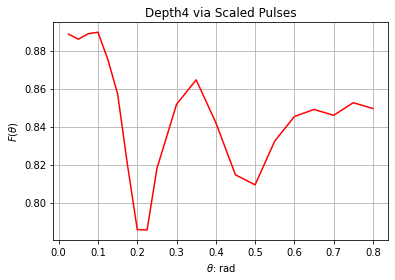

In [130]:

plt.plot([float(k) for k in keys],[fidelities[k] for k in keys],c='r')
plt.xlabel(r'$\theta$: rad')
plt.ylabel(r'$F(\theta)$')
plt.title(r'Depth4 via Scaled Pulses')
plt.grid()
plt.savefig(f'plots/depth4.{label}.png', transparent=False)

In [ ]:
label= '14.June'

with open(f'results/{device_name}/{label}/depth4/full_results.q4q5q6.pickle', 'rb') as handle:
    results14 = pickle.load(handle)
    
with open(f'results/{device_name}/{label}/depth4/qpt_exps.q4q5q6.pickle', 'rb') as handle:
    qpt_experiments14 = pickle.load(handle)
    
label= '15.June'

with open(f'results/{device_name}/{label}/depth4/full_results.q4q5q6.pickle', 'rb') as handle:
    results15 = pickle.load(handle)
    
with open(f'results/{device_name}/{label}/depth4/qpt_exps.q4q5q6.pickle', 'rb') as handle:
    qpt_experiments15 = pickle.load(handle)